# Defining a DCR metric

We need to be able to predict whether a given set of observations will be able to constrain the DCR model, and evaluate how accurately the model should be able to create a matched template for a new observation. This notebook explores two different ways to define a metric 



In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import lsst.geom as geom
import lsst.daf.persistence as dafPersist

In [2]:
import scipy.stats

## Define (gen 2) butlers to access the 2014 and 2015 DeCam HiTS data

In [3]:
repoTemplate = '/project/sullivan/hits2014/dcrcoadds_processed/'
butlerTemplate = dafPersist.Butler(repoTemplate)
repoAlerts = '/project/sullivan/hits2015/ap_pipe/dcr_processed'
butlerAlerts = dafPersist.Butler(repoAlerts)

Load a coadd, and use the coaddinputs to determine the visits and ccds that contributed to it. This is a butler gen 2 way of identifying calexps that contribute to a given patch.

In [4]:
patch = '41,48'

In [5]:
templateCoadd = butlerTemplate.get("deepCoadd", dataId={'tract':0,'patch':patch,'filter':'g'})

In [6]:
templateInputs = templateCoadd.getInfo().getCoaddInputs()

The DeCam visit 'id' encodes both the visit number and the CCD number

In [7]:
templateVisits = templateInputs.ccds['id'] // 100

In [8]:
templateCcds = templateInputs.ccds['id'] - templateVisits*100

Find the unique visit numbers (each visit might otherwise be repeated for each CCD)

In [9]:
print(set(templateVisits))

{289155, 289050, 289691, 289823, 289567, 288929, 289444, 289196, 292404, 289608, 289865, 288970, 289486, 289362, 289237, 289777, 289010, 289650, 289907, 289403, 289278}


Find the unique CCD numbers (each CCD might otherwise be repeated for each visit)

In [10]:
print(set(templateCcds))

{41, 42, 35, 36}


Pick a single CCD

In [11]:
ccd = 42

In [12]:
templateVinfos = [butlerTemplate.get("calexp_visitInfo", dataId={'filter':'g', 'ccdnum':ccd, 'visit':visit}) for visit in set(templateVisits)]

In [13]:
alertsVisits = set([410929,410985,411035,411069,411269,411319,411369,411420,411470,411671,411721,411772,411822,411872,412074,412264,412321,412518,412568,412618,412668,412718,413649,413694,415328,415378,419802])

In [14]:
alertsVinfos = [butlerAlerts.get("calexp_visitInfo", dataId={'filter':'g', 'ccdnum':ccd, 'visit':visit}) for visit in alertsVisits]

In [15]:
vtest = alertsVinfos[0]

In [16]:
vtest.getExposureId()//100

411269

In [17]:
vtest.getBoresightParAngle()

-2.17508 rad

Create a dummy pandas database to illustrate functionality

In [18]:
df = pd.DataFrame(columns=['airmass', 'hour_angle'], dtype='float')

In [19]:
print(df)

Empty DataFrame
Columns: [airmass, hour_angle]
Index: []


Demonstrate how adding and removing visits and their associated metadata works

In [20]:
df.loc[411956] = [1.36, -2.34]
df.loc[411986] = [1.06, 1.12]
print(df)

        airmass  hour_angle
411956     1.36       -2.34
411986     1.06        1.12


It doesn't raise an error to drop an empty list

In [21]:
df.drop([])

,airmass,hour_angle
411956,1.36,-2.34
411986,1.06,1.12


In [22]:
df['airmass'][[411956, 411986]]

411956    1.36
411986    1.06
Name: airmass, dtype: float64

It's perfectly valid to add (and remove) a NAN visit

In [23]:
df.loc[np.nan] = [2.34, 0.001]

In [24]:
for ind in df.index: print(ind)

411956.0
411986.0
nan


In [25]:
df.drop(np.nan, inplace=True)
for ind in df.index: print(ind)

411956.0
411986.0


# DCR for a visit is defined by it's airmass and parallactic angle
(We'll ignore secondary effects such as temperature and humidity variations)

Celestial sources follow a circular path (ignoring precession, etc..), so our 2D parameter space is really only 1D. That means all we need to characterize DCR is the airmass and whether the target is rising or setting, i.e. the sign of the hour angle. For this notebook, I'll call the parameter defined by combining those to be the "visit measure":

visit_measure = (airmass - 1) x sign(hour angle)

In [26]:
test_airmass = 1.3
test_ha = -1.

# First approach: histogram of the visit measure

This is a simple approach to define a DCR metric: The DCR model is well constrained if the input observations have a wide range of visit measures, and good sampling throughout that range. To evaluate this, we can create histograms of the visit measures at different scales. A good metric is then the number of total bins with data, though we can improve this further by giving greater weight to the coarser histogram bins.

This method is straightforward, and also allows us to test the improvement of the metric from adding a new observation, or how much it would be hurt if an observation had to be dropped (perhaps from a seeing cut).


In [27]:
class DcrMetric1:
    def __init__(self, max_airmass=1.8, base_nbins=6):
        self.max_airmass = max_airmass
        self.hist_range = [1 - max_airmass, max_airmass - 1]
        self.base_nbins = 6
        self.nbin_multipliers = [1, 2, 4]
        self.kde = None
        self.hist = []
        self.weight = []
        for multiplier in self.nbin_multipliers:
            self.weight.append(np.product(self.nbin_multipliers)/multiplier)
            self.hist.append(np.histogram(np.nan, self.base_nbins*multiplier, range=self.hist_range)[0])
        
        self.table = pd.DataFrame(columns=['airmass', 'hour_angle'], dtype='float')  # visit will be the index
        
    @property
    def metricThreshold(self):
        """Calculate the minimum metric necessary to constrain the DCR model."""
        metrics = [weight/nbins for nbins, weight in zip(self.nbin_multipliers, self.weight)]
        metric = np.sum(metrics)/np.sum(self.weight)
        return metric
    
    def getBin(self, measure, h_ind):
        """Find the bin of the histogram for a given visit measure."""
        binsize = (self.hist_range[1] - self.hist_range[0])/(self.base_nbins*self.nbin_multipliers[h_ind])
        h_bin = int(np.floor((measure - self.hist_range[0])/binsize))
        return h_bin
    
    def _updateHist(self, visit_measure, delete=False):
        for h_ind, multiplier in enumerate(self.nbin_multipliers):
            hist = np.histogram(visit_measure, self.base_nbins*multiplier, range=self.hist_range)[0]
            if delete:
                self.hist[h_ind] -= hist
            else:
                self.hist[h_ind] += hist
                
    def parameterizeVisit(self, airmass, hour_angle):
        """Convert airmass and hour angle to visit measure."""
        visit_measure = (airmass - 1.)*np.sign(hour_angle)
        return visit_measure
            
    def addVisit(self, visit, airmass, hour_angle):
        """Update the database with a new observation."""
        if visit in self.table.index:
            raise KeyError(f"Visit {visit} is already present in the table, and cannot be added. Skipping it.")
        self.table.loc[visit] = [airmass, hour_angle]
        visit_measure = self.parameterizeVisit(airmass, hour_angle)
        self._updateHist(visit_measure)
        
    def addVisitInfo(self, visitInfo):
        """Update the database with a new observation using an exposures visitInfo."""
        visit = visitInfo.getExposureId()//100
        hour_angle = visitInfo.getBoresightHourAngle().asRadians()
        airmass = visitInfo.getBoresightAirmass()
        self.addVisit(visit, airmass, hour_angle)
    
    def delVisit(self, visit):
        """Update the database by removing a visit."""
        try:
            airmass = self.table['airmass'][visit]
            hour_angle = self.table['hour_angle'][visit]
            self.table.drop(visit, inplace=True)
        except Exception:
            raise KeyError(f"Could not remove visit {visit}, it is not in the table.")
        else:
            visit_measure = self.parameterizeVisit(airmass, hour_angle)
            self._updateHist(visit_measure, delete=True)
    
    def testAddVisit(self, airmass, hour_angle, threshold=1):
        """Calculate the metric improvement if a new observation were added."""
        visit = np.nan
        visit_measure = self.parameterizeVisit(airmass, hour_angle)
        improvement = 0.
        for h_ind, multiplier in enumerate(self.nbin_multipliers):
            hist = np.histogram(visit_measure, self.base_nbins*multiplier, range=self.hist_range)[0]
            h_bin = np.argmax(hist)
            if self.hist[h_ind][h_bin] == (threshold - 1):
                improvement += hist[h_bin]*self.weight[h_ind]/(len(hist)*np.sum(self.weight))
        return improvement
    
    def testDelVisit(self, visits, threshold=1):
        """Calculate the metric regression if an existing observation were excluded."""
        visit_measures = []
        improvement = 0.
        if not isinstance(visits, list):
            visits = [visits,]
        for visit in visits:
            airmass = self.table['airmass'][visit]
            hour_angle = self.table['hour_angle'][visit]
            visit_measures.append(self.parameterizeVisit(airmass, hour_angle))
        for h_ind, multiplier in enumerate(self.nbin_multipliers):
            hist = np.histogram(visit_measures, self.base_nbins*multiplier, range=self.hist_range)[0]
            count0 = np.sum(self.hist[h_ind] >= threshold)
            count1 = np.sum((self.hist[h_ind] - hist) >= threshold)
            improvement += (count1 - count0)*self.weight[h_ind]/(len(hist)*np.sum(self.weight))
        return improvement
    
    def calculateMetric(self, exclude=None, threshold=1):
        """Calculate the DCR metric for the observations in the database."""
        metrics = [np.mean(hist >= threshold)*weight for hist, weight in zip(self.hist, self.weight)]
        metric = np.sum(metrics)/np.sum(self.weight)
        return metric
    
    def calculateKde(self):
        """Calculate a Kernel Density Estimator for the observations in the database."""
        visit_measures = []
        for visit in self.table.index:
            airmass = self.table['airmass'][visit]
            hour_angle = self.table['hour_angle'][visit]
            measure = self.parameterizeVisit(airmass, hour_angle)
            if measure >= self.hist_range[0] and measure <= self.hist_range[1]:
                visit_measures.append(measure)
        kde_width = 2*(self.hist_range[1] - self.hist_range[0])/self.base_nbins
        self.kde = []
        for multiplier in self.nbin_multipliers:
            density = kde_width/multiplier
            weight_kde = scipy.stats.gaussian_kde(visit_measures, bw_method=density)
            weights = 1/weight_kde(visit_measures)
            self.kde.append(scipy.stats.gaussian_kde(visit_measures, bw_method=density, weights=weights))
    
    def evaluateVisit(self, airmass, hour_angle, doPlot=True, fig_id=1000):
        """Use the KDE to test whether a well-constrained template can be made for an observation."""
        if self.kde is None:
            self.calculateKde()
        visit_measure = self.parameterizeVisit(airmass, hour_angle)
        distance = []
        count = []
        density = []
        if doPlot:
            visit_measures =[]
            xv = np.arange(self.hist_range[0]-.3, self.hist_range[1]+.3, .01)
            for visit in self.table.index:
                airmass = self.table['airmass'][visit]
                hour_angle = self.table['hour_angle'][visit]
                visit_measures.append(self.parameterizeVisit(airmass, hour_angle))
        for h_ind, multiplier in enumerate(self.nbin_multipliers):
            kde = self.kde[h_ind]
            if doPlot:
                nVisits = len(visit_measures)
                plt.figure(fig_id + h_ind)
                plt.hist(visit_measures, range=self.hist_range, bins=self.base_nbins*multiplier)
                plt.plot(visit_measures, np.ones(nVisits),'+')
                plt.plot(xv, kde(xv),'-')
                plt.plot(visit_measure, 2.,'x')
                plt.legend(["Visit measures", "KDE", "Science observation visit measure",
                            "Histogram of visit measures"])
            density.append(kde(visit_measure))
        metrics = [d*weight for d, weight in zip(density, self.weight)]
        metric = np.sum(metrics)/np.sum(self.weight)
#         print(distance, count, density)
#         print(metric, metric*self.calculateMetric())
        return metric*self.calculateMetric()
        
    def evaluateVisitInfo(self, visitInfo):
        """Use the KDE to test whether a well-constrained template can be made for an observation, using the visitInfo."""
        hour_angle = visitInfo.getBoresightHourAngle().asRadians()
        airmass = visitInfo.getBoresightAirmass()
        return self.evaluateVisit(airmass, hour_angle)

In [28]:
dcrMetric1_hits2014 = DcrMetric1()
for vinfo in templateVinfos:
    dcrMetric1_hits2014.addVisitInfo(vinfo)

In [29]:
dcrMetric1_hits2015 = DcrMetric1()
for vinfo in alertsVinfos:
    dcrMetric1_hits2015.addVisitInfo(vinfo)

In [30]:
print(dcrMetric1_hits2014.testAddVisit(1.5, 1))
print(dcrMetric1_hits2015.testAddVisit(1.5, 1))

0.125
0.02976190476190476


In [31]:
print(f"Metric threshold for HiTS 2014 model: {dcrMetric1_hits2014.metricThreshold}")
print(f"Metric threshold for HiTS 2015 model: {dcrMetric1_hits2015.metricThreshold}")

Metric threshold for HiTS 2014 model: 0.75
Metric threshold for HiTS 2015 model: 0.75


## The metric threshold is a reference value above which the DCR model is well constrained

In [32]:
print(f"Metric for DCR model built from HiTS 2014: {dcrMetric1_hits2014.calculateMetric()}")
print(f"Metric for DCR model built from HiTS 2015: {dcrMetric1_hits2015.calculateMetric()}")

Metric for DCR model built from HiTS 2014: 0.5119047619047619
Metric for DCR model built from HiTS 2015: 0.7142857142857143


Note that by this standard, neither the 2014 or 2015 surveys are sufficient to constrain the DCR model. However, HiTS 2015 is almost equal to the threshold, and is much better than HiTS 2014.

<IPython.core.display.Javascript object>


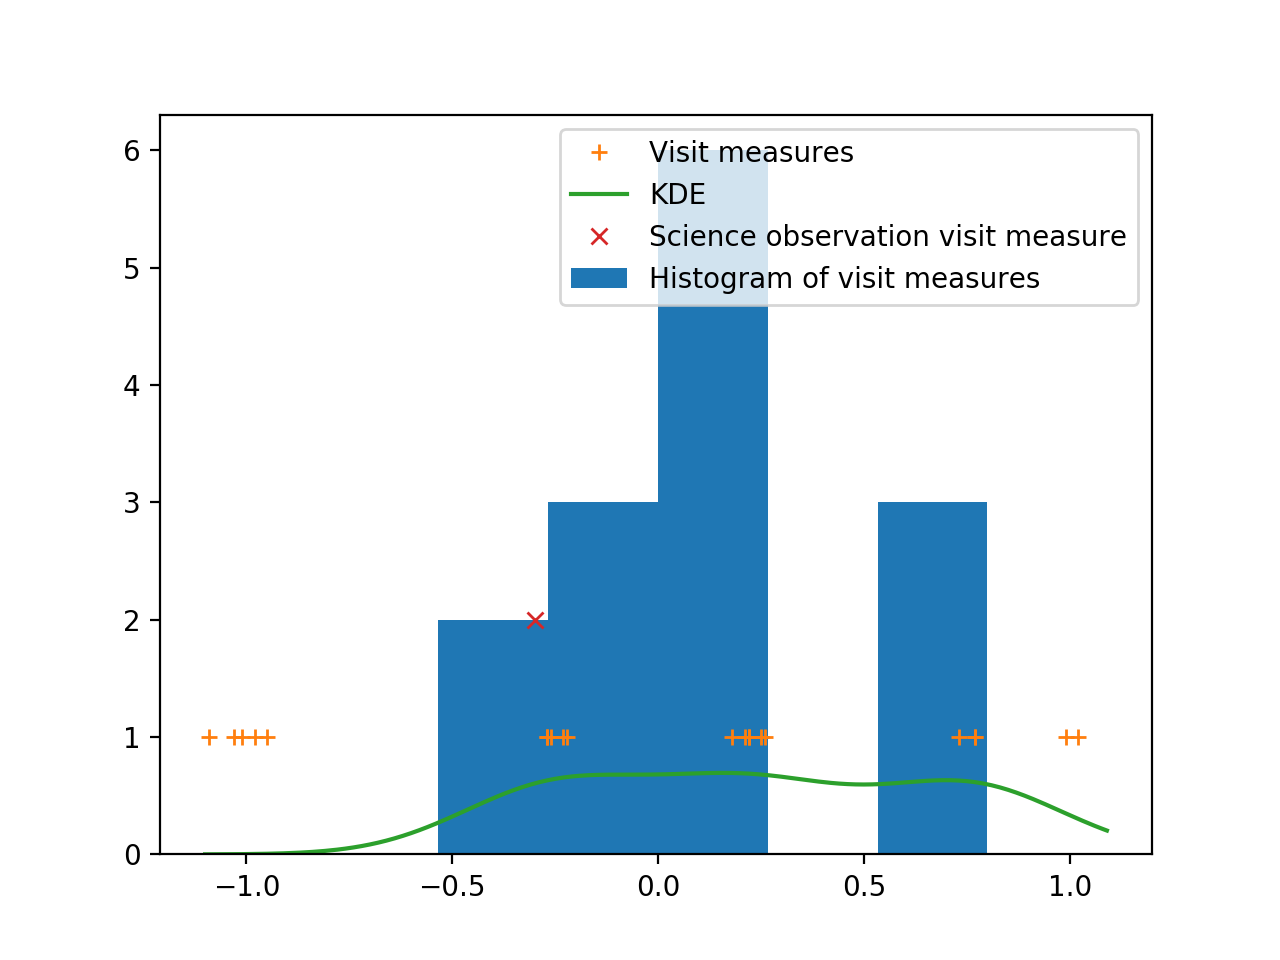

<IPython.core.display.Javascript object>


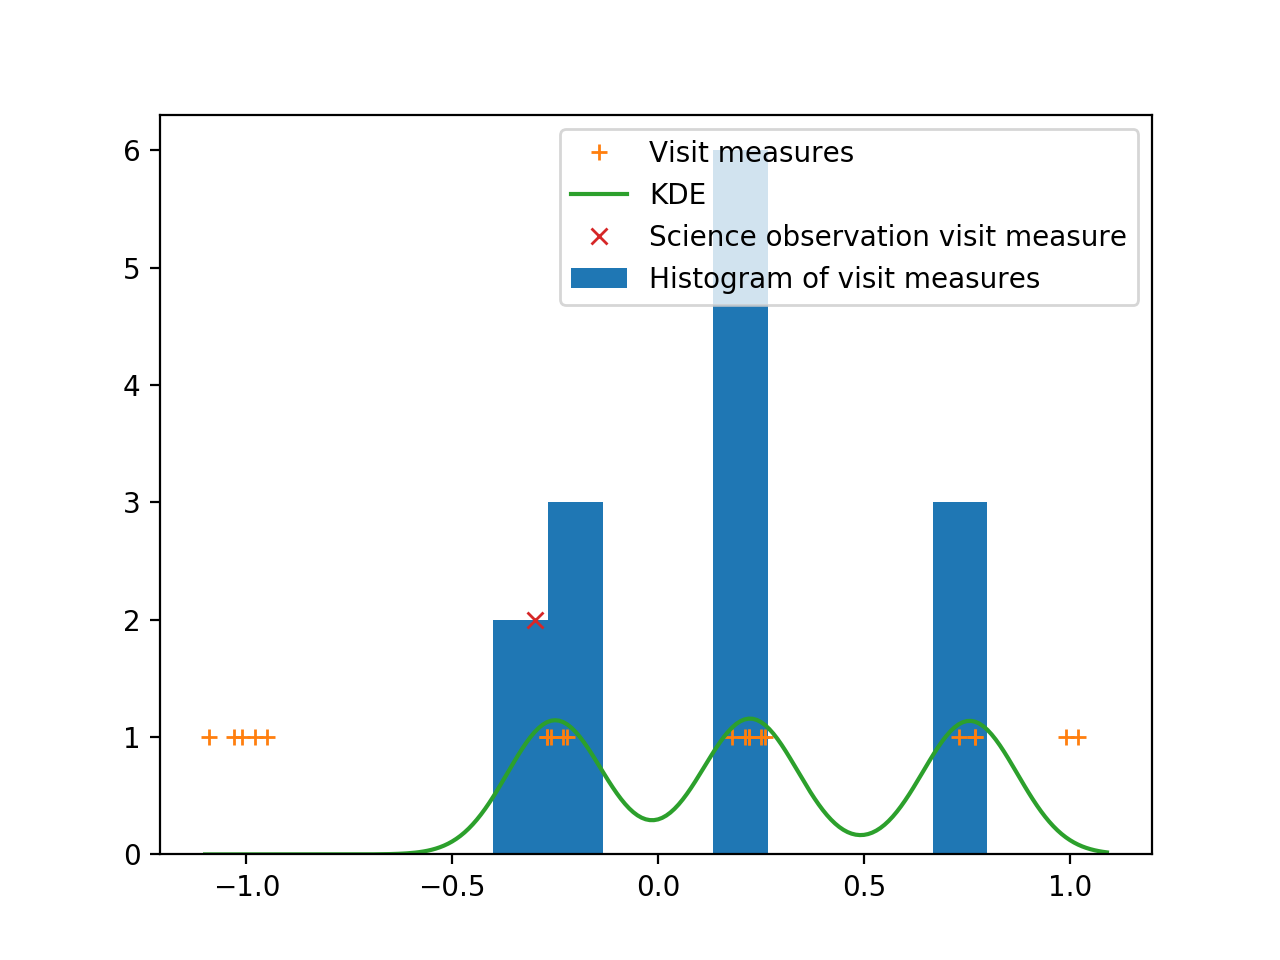

<IPython.core.display.Javascript object>


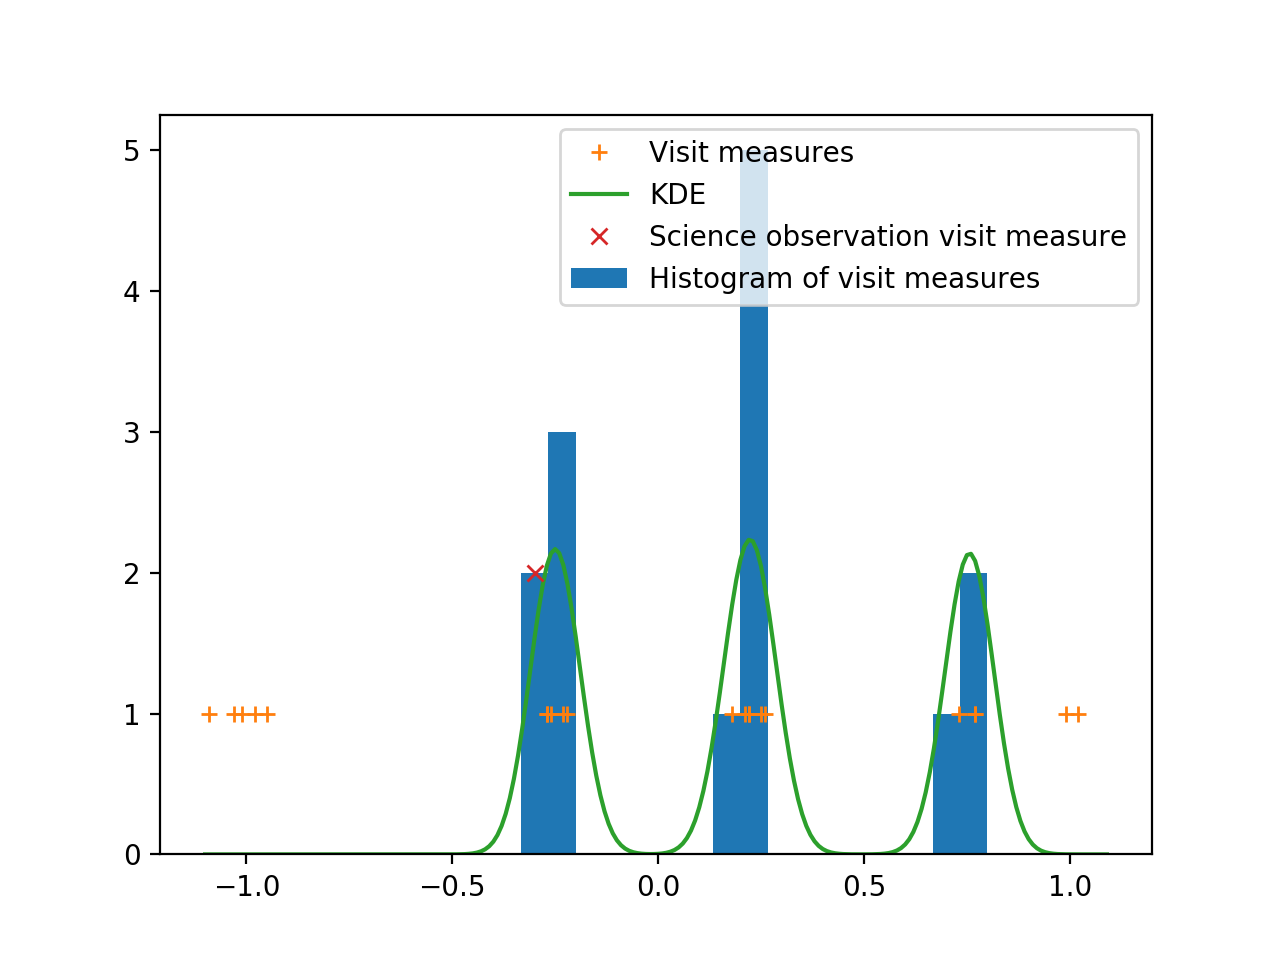

<IPython.core.display.Javascript object>


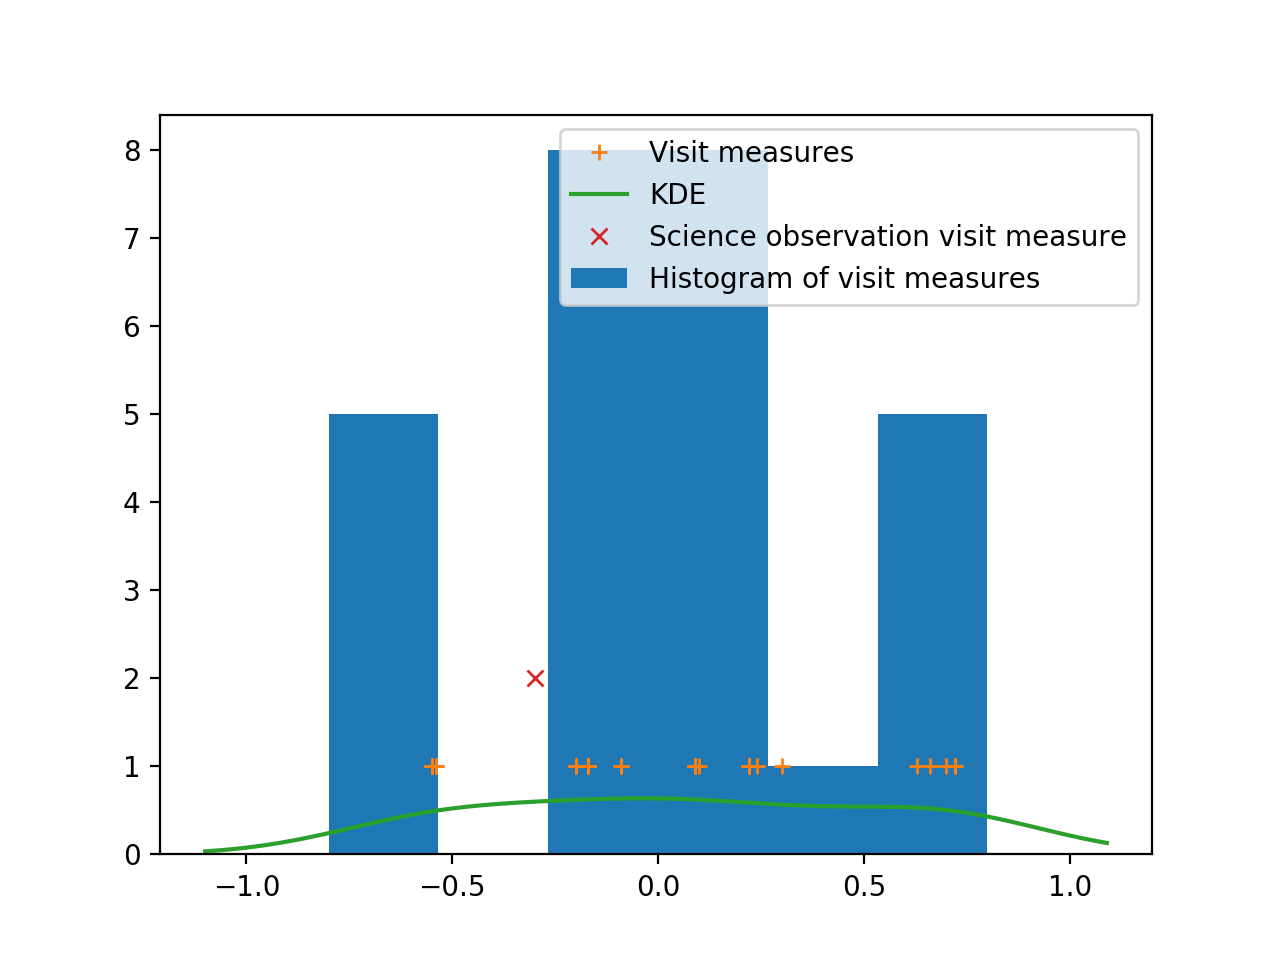

<IPython.core.display.Javascript object>


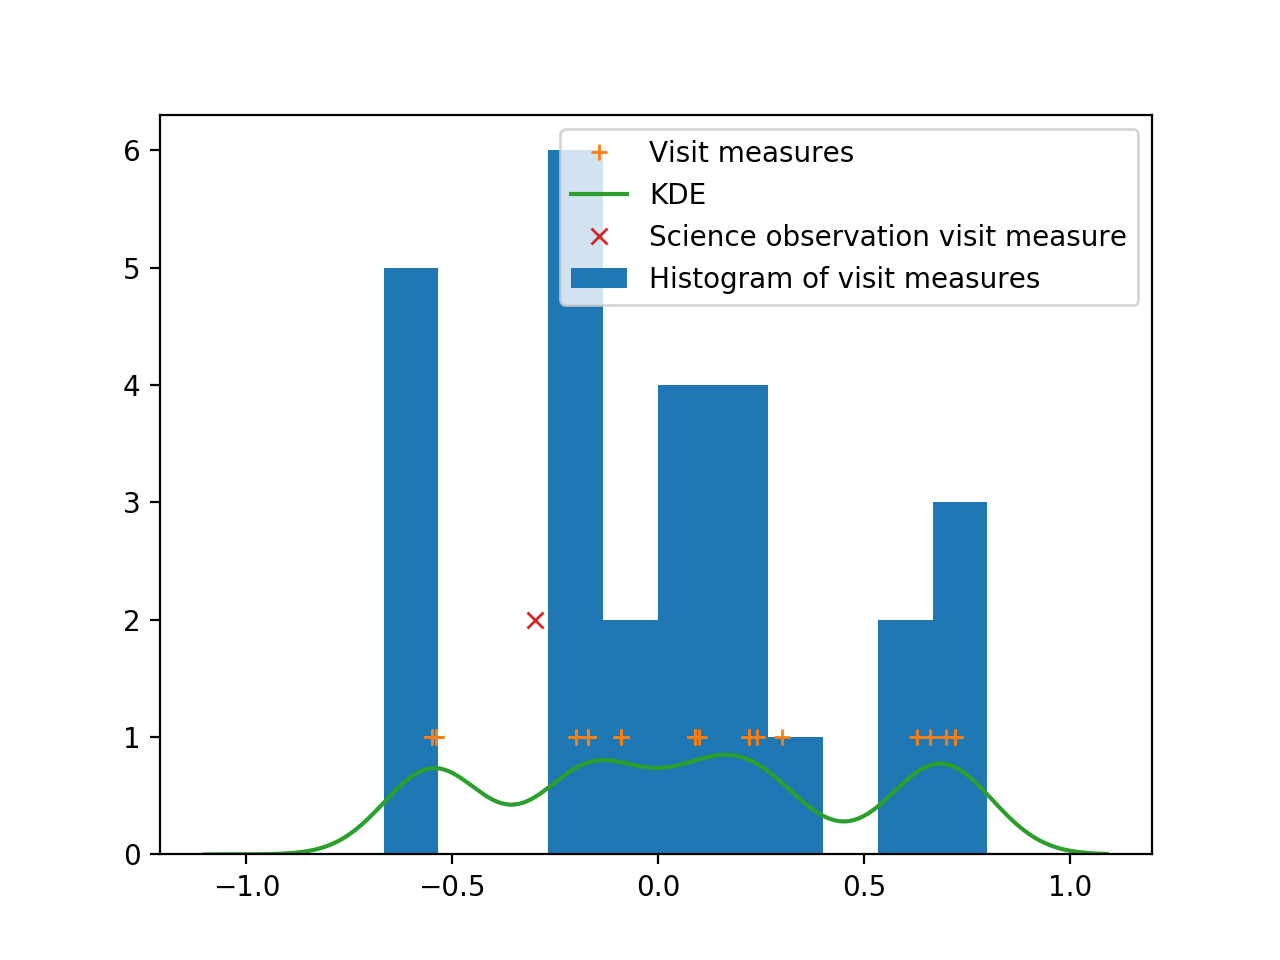

<IPython.core.display.Javascript object>


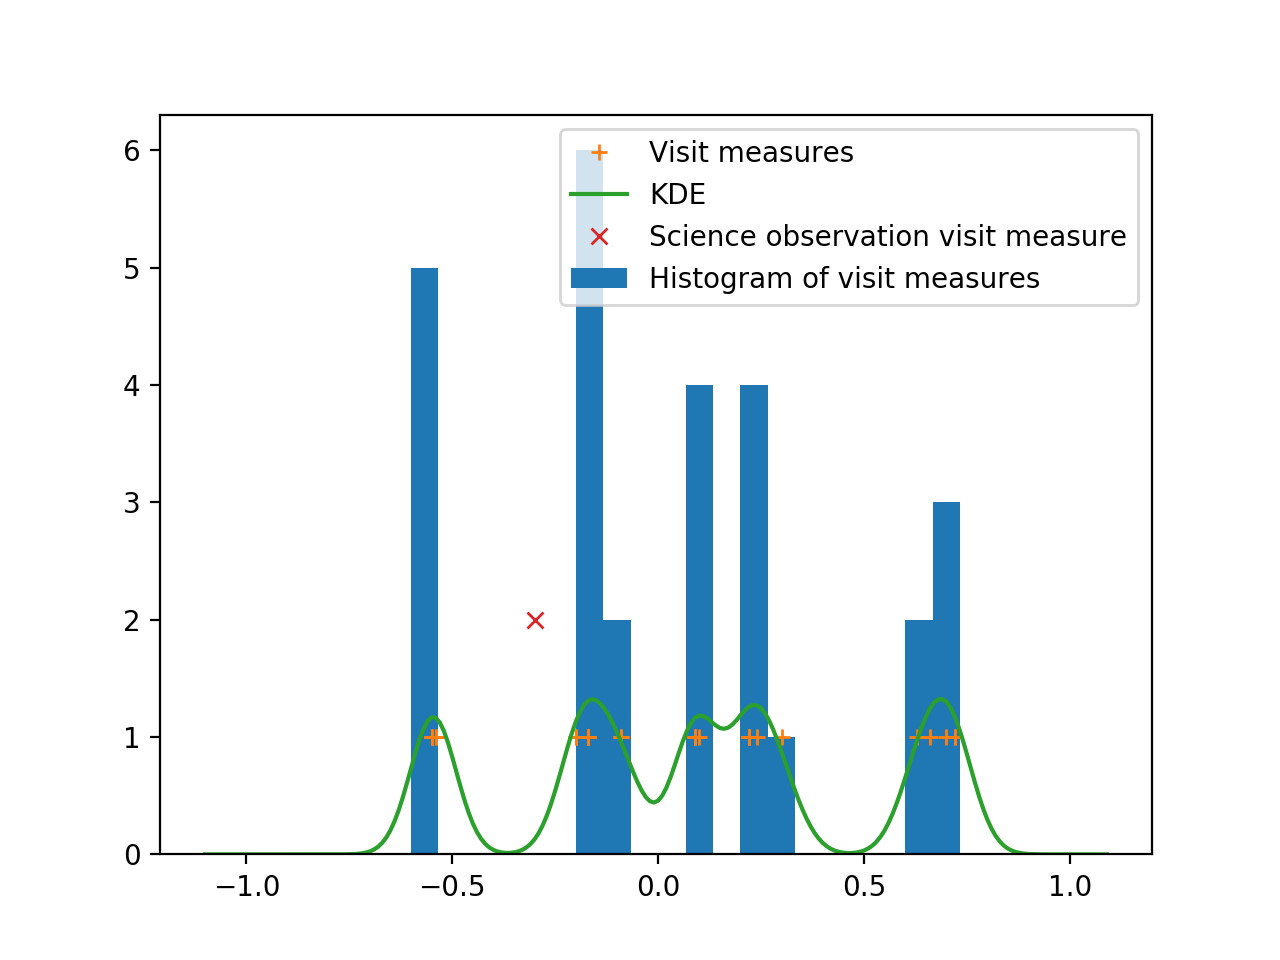

In [33]:
metric1_hits2014 = dcrMetric1_hits2014.evaluateVisit(test_airmass, test_ha, fig_id=2)
metric1_hits2015 = dcrMetric1_hits2015.evaluateVisit(test_airmass, test_ha, fig_id=5)

In [34]:
print(f"Science observation metric using 2014 template: {metric1_hits2014}")
print(f"Science observation metric using 2015 template: {metric1_hits2015}")

Science observation metric using 2014 template: 0.44143917876926625
Science observation metric using 2015 template: 0.35692672565334027


## Notes on the histogram method:
The above metric seems like a reasonable evaluation of the overall quality of the DCR model, but more work needs to be done to evaluate the fit for a target science observation. Also, it seems awkward that it uses both histograms and a KDE. The KDE requires much more work to be useful (see below), at which point it would seem natural to switch to the KDE for everything.

The histogram approach has the benefit of simplicity. You don't need to store any of the actual airmass or hour angle values, even if you want to be able to later add or remove observations, since you can simply update the histogram. However, if you want to evaluate a new (science) observation, you need the KDE which does require storing those values, so much of the benefit is lost.

# A second approach: Kernel Density Estimator (KDE)

As noted above, we could skip the histograms entirely and instead calculate both the metrics and the fit for a new science observation using Kernel Density Estimators (KDEs). A KDE is like a smooth and continuous histogram, so it avoids the main problem with the histogram approach, where two observations with similar visit measures might fall in either one or two bins depending on the arbitrary bin boundaries. For example, the metric for the 2014 HiTS data is inflated because the tight cluster of visit measures around -.25 happen to fall in two coarse bins.

The downsides to using a KDE for everything are that it is much harder to normalize, you have to maintain a database of all observations, and it must be recalculated every time you add or remove observations.

# The DCR metric

The metric is calculated as the significance of each input observation, added in quadrature.
The significance of an observation is the the inverse of the weight, or density, KDE evaluated at the observation's visit measure.
Thus, the significance of an individual observation is 1 when it is the only one constraining its region, but decreases when there are many other observations at similar observing conditions.

For ease of use, the final metric is divided by the metric calculated for a set of well-sampled reference observations, so that any metric greater than one signifies that the model is sufficiently constrained.

In [35]:
class DcrMetric2:
    def __init__(self, max_airmass=1.8, width=0.4):
        self.max_airmass = max_airmass
        self.range = [1 - max_airmass, max_airmass - 1]
        self.width = width
        self.kde = None
        self.density = None
        self.norm = None
        self.metric = None
        self.table = pd.DataFrame(columns=['airmass', 'hour_angle'], dtype='float')  # visit will be the index
        self.metric_reference = self.calculateReference()
                
    def parameterizeVisit(self, airmass, hour_angle):
        """Convert airmass and hour angle to visit measure.
        
        Parameters
        ----------
        airmass: `float`
            The observed airmass of the observation.
        hour_angle: `float`
            The observed hour angle of the observation.
        
        Returns
        -------
        visit_measure: `float`
            A one dimensional parameterization of airmass and hour angle.
        """
        visit_measure = (airmass - 1.)*np.sign(hour_angle)
        return visit_measure
    
    def parameterizeTable(self, visits=None):
        """Calculate the visit measures for all observations in the database.
        
        Parameters
        ----------
        visits: `list`, optional
            The visit identifiers of the desired observations.
            If `None`, all observations in the database are used.
        
        Returns
        -------
        visit_measures : `list` of `float`
            The one-dimensional parameterization of airmass and hour angle for all visits in the database.
        """
        visit_measures = []
        if visits is None:
            visits = self.table.index
        for visit in visits:
            airmass = self.table['airmass'][visit]
            hour_angle = self.table['hour_angle'][visit]
            measure = self.parameterizeVisit(airmass, hour_angle)
            if measure >= self.range[0] and measure <= self.range[1]:
                visit_measures.append(measure)
        return visit_measures

    def addVisit(self, visit, airmass, hour_angle):
        """Add a new visit to the database.
        
        Parameters
        ----------
        visit: `float`
            The visit identifier of the observation to be added.
        airmass: `float`
            The observed airmass of the observation.
        hour_angle: `float`
            The observed hour angle of the observation.
        """
        if visit in self.table.index:
            raise KeyError(f"Visit {visit} is already present in the table, and cannot be added. Skipping it.")
        self.table.loc[visit] = [airmass, hour_angle]
        self.kde = None
        
    def addVisitInfo(self, visitInfo):
        """Add a new visit to the database using the VisitInfo of an exposure.
        
        Parameters
        ----------
        visitInfo: `lsst.afw.image.VisitInfo`
            The VisitInfo metadata of an exposure.
        """
        visit = visitInfo.getExposureId()//100  # This is Decam-specific
        hour_angle = visitInfo.getBoresightHourAngle().asRadians()
        airmass = visitInfo.getBoresightAirmass()
        self.addVisit(visit, airmass, hour_angle)
    
    def delVisit(self, visit):
        """Remove a visit from the database.
        
        Parameters
        ----------
        visit: `float`
            The visit identifier of the observation to be removed.
        """
        try:
            airmass = self.table['airmass'][visit]
            hour_angle = self.table['hour_angle'][visit]
            self.table.drop(visit, inplace=True)
        except Exception:
            raise KeyError(f"Could not remove visit {visit}, it is not in the table.")
        else:
            self.kde = None
    
    def testVisit(self, airmass=None, hour_angle=None, visit_measure=None):
        """Evaluate how significant a new observation will be to constrain DCR.
        
        Parameters
        ----------
        airmass: `float`, optional
            The observed airmass of the observation.
        hour_angle: `float`, optional
            The observed hour angle of the observation.
        visit_measure: `float`, optional
            The one-dimensional parameterization of airmass and hour angle.
        """
        self.checkKde()
        if visit_measure is None:
            visit_measure = self.parameterizeVisit(airmass, hour_angle)
        weight = 1./(self.evaluateKde(visit_measure)*self.density(visit_measure))
        return weight
    
    def checkKde(self):
        """Check if the KDE exists, and calculate it from the database if not.
        """
        if self.kde is None:
            self.kde, self.density = self.calculateKde(return_weights=True)
            self.norm = self.calculateNormalization()
            self.metric = self.calculateMetric()
    
    def calculateKde(self, visit_measures=None, return_weights=False):
        """Calculate the KDE for a given list of visit measures.
        
        Parameters
        ----------
        visit_measures: `list` of `float`, optional
            The list of visit measures to calculate the KDE for.
            If not supplied, the visit measures stored in the database will be used.
        return_weights: `bool`
            Return the weights KDE as well as the normalized KDE?
        
        Returns
        -------
        kde: `scipy.stats.kde.gaussian_kde`
            Normalized KDE of the visit measures.
        density_kde: `scipy.stats.kde.gaussian_kde`, if ``return_weights`` is set
            Raw KDE of the visit measures.
        """
        if visit_measures is None:
            visit_measures = self.parameterizeTable()
        density_kde = scipy.stats.gaussian_kde(visit_measures, bw_method=self.width**2)
        visit_weights = 1/density_kde(visit_measures)
        kde = scipy.stats.gaussian_kde(visit_measures, bw_method=self.width, weights=visit_weights)
        if return_weights:
            return(kde, density_kde)
        else:
            return kde
        
    def calculateReference(self):
        """Calculate the metric for a reference distribution of visit measures.
        
        Returns
        -------
        metric: `float`
            The metric of the reference visit measures.
        """
        test_measures = np.linspace(self.range[0], self.range[1], num=8, endpoint=True)
        kde, density_kde = self.calculateKde(visit_measures=test_measures, return_weights=True)
        self.ref_kde = kde
        self.ref_density_kde = density_kde
        metric = self._calculateMetric(density_kde=density_kde, visit_measures=test_measures, use_reference=False)
        return metric
    
    def calculateNormalization(self, kde=None):
        """Normalize the KDE to integrate to one over one unit of visit measure.
        
        Parameters
        ----------
        kde: `scipy.stats.kde.gaussian_kde`, optional
            The KDE to normalize.
            Uses ``self.kde`` if not supplied.
            
        Returns
        -------
        normalization: `float`
            The normalization factor for the given KDE.
        """
        if kde is None:
            self.checkKde()
            kde = self.kde
        normalization = (self.range[1] - self.range[0])/kde.integrate_box(*self.range)
        return normalization
    
    def calculateMetric(self, kde=None):
        """Calculate the DCR metric for a given KDE.
        
        Parameters
        ----------
        kde: `scipy.stats.kde.gaussian_kde`, optional
            Uses ``self.kde`` if not supplied.
        
        Returns
        -------
        metric: `float`
            The metric evaluating how well DCR is constrained for the given KDE.
        """
        if kde is None:
            self.checkKde()
            kde = self.kde
        metric = self._calculateMetric(self.density, self.kde.dataset)
        return metric
    
    def _calculateMetric(self, density_kde=None, visit_measures=None, use_reference=True):
        if density_kde is None:
            density_kde = self.density
        if visit_measures is None:
            visit_measures = self.kde.dataset
        visit_weights = 1./(density_kde(visit_measures))**2
        metric = np.sqrt(np.sum(visit_weights))
        if use_reference:
            metric /= self.metric_reference
        return metric
    
    def evaluateKde(self, visit_measure):
        """Evaluate how well DCR is constrained for an observation.
        
        Parameters
        ----------
        visit_measure: `float`
            The one-dimensional parameterization of airmass and hour angle.
        
        Returns
        -------
        visit_metric: `float`
            The metric evaluating how well a new observation can be constrained for the current DCR model.
        """
        template_metric = self.metric
        visit_metric = self.kde(visit_measure)
        visit_metric *= self.norm*template_metric
        return visit_metric
    
    def evaluateVisit(self, airmass, hour_angle):
        """Evaluate how well DCR is constrained for an observation.
        
        Parameters
        ----------
        airmass: `float`
            The observed airmass of the observation.
        hour_angle: `float`
            The observed hour angle of the observation.
        
        Returns
        -------
        visit_metric: `float`
            The metric evaluating how well a new observation can be constrained for the current DCR model.
        """
        self.checkKde()
        visit_measure = self.parameterizeVisit(airmass, hour_angle)
        visit_metric = self.evaluateKde(visit_measure)
        return visit_metric
        
    def evaluateVisitInfo(self, visitInfo):
        """Evaluate how well DCR is constrained for an observation.
        
        Parameters
        ----------
        visitInfo: `lsst.afw.image.VisitInfo`
            The VisitInfo metadata of an exposure.
        
        Returns
        -------
        visit_metric: `float`
            The metric evaluating how well a new observation can be constrained for the current DCR model.
        """
        hour_angle = visitInfo.getBoresightHourAngle().asRadians()
        airmass = visitInfo.getBoresightAirmass()
        return self.evaluateVisit(airmass, hour_angle)
    
    def plotMetric(self, window=1000, plot_measures=True):
        """Generate a plot to visualize the KDE and the input visit measures.
        
        Parameters
        ----------
        window: `int`
            The figure number to add the new plots to.
        plot_measures: `bool`
            Overplot the visit measures of the input observations.
        """
        self.checkKde()
        visit_measures = self.parameterizeTable()
        xv = np.arange(self.range[0]-.3, self.range[1]+.3, .01)
        nVisits = len(visit_measures)
        plt.figure(window)
        metric_values = self.evaluateKde(xv)
        plt.plot(xv, metric_values,'-')
        if plot_measures:
            plt.plot(visit_measures, np.ones(nVisits),'+')

## Initial test: Visits that perfectly match the reference should have a metric of 1

<IPython.core.display.Javascript object>


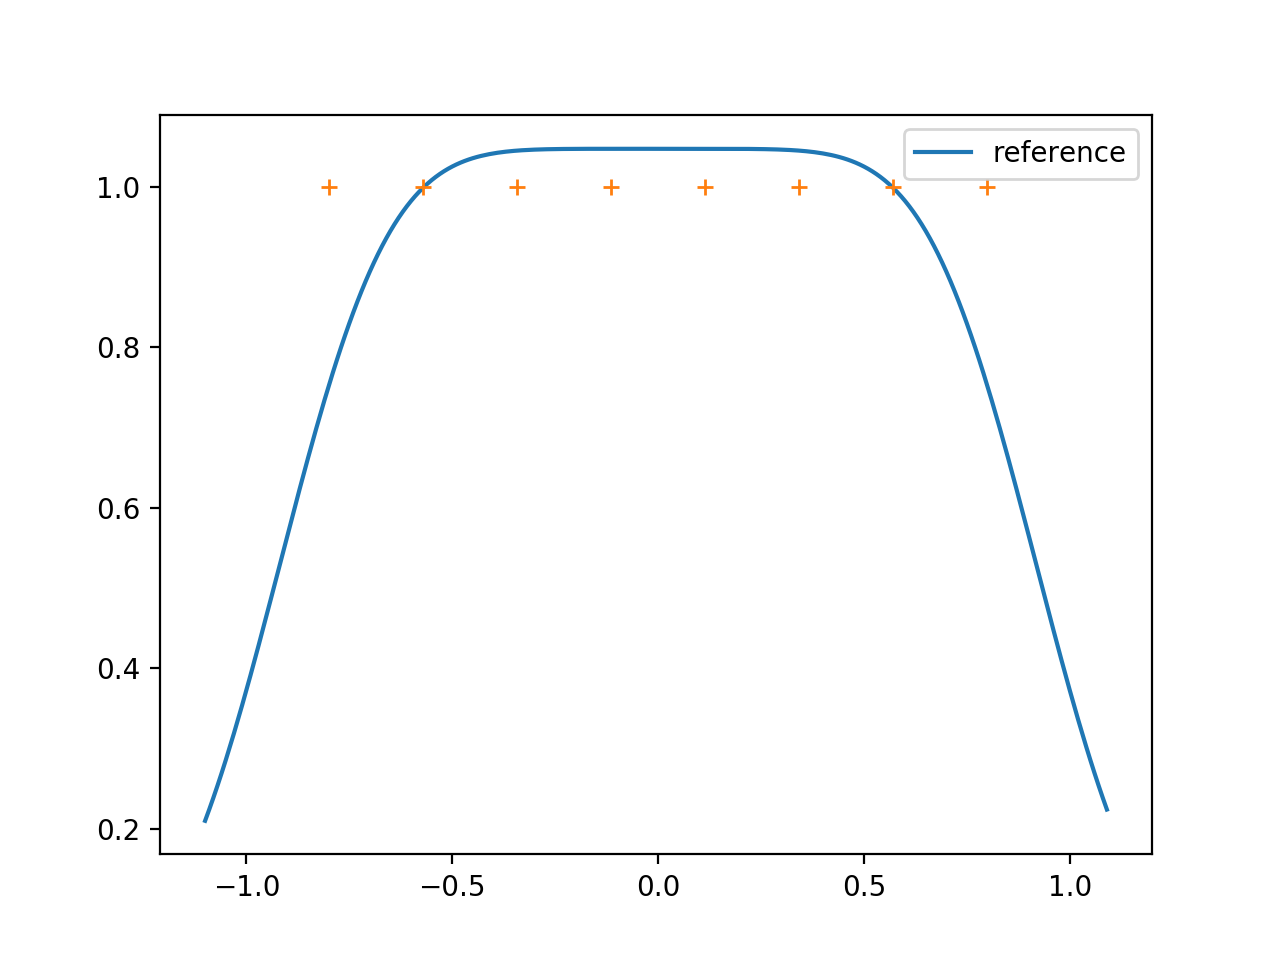

Metric: 1.0


In [36]:
dcrMetric2_reference = DcrMetric2()
for measure in np.linspace(*dcrMetric2_reference.range, num=8, endpoint=True):
    airmass = np.abs(measure) + 1.
    ha = np.sign(measure)
    dcrMetric2_reference.addVisit(measure, airmass, ha)
dcrMetric2_reference.plotMetric(window=8)
plt.legend(['reference'])
print(f"Metric: {dcrMetric2_reference.metric}")

Ideally, the above plot should be mostly flat between the outermost +'s, close to (or just above) 1, and fall off quickly towards 0.

## Increasing the number and density of visits should improve the metric

<IPython.core.display.Javascript object>


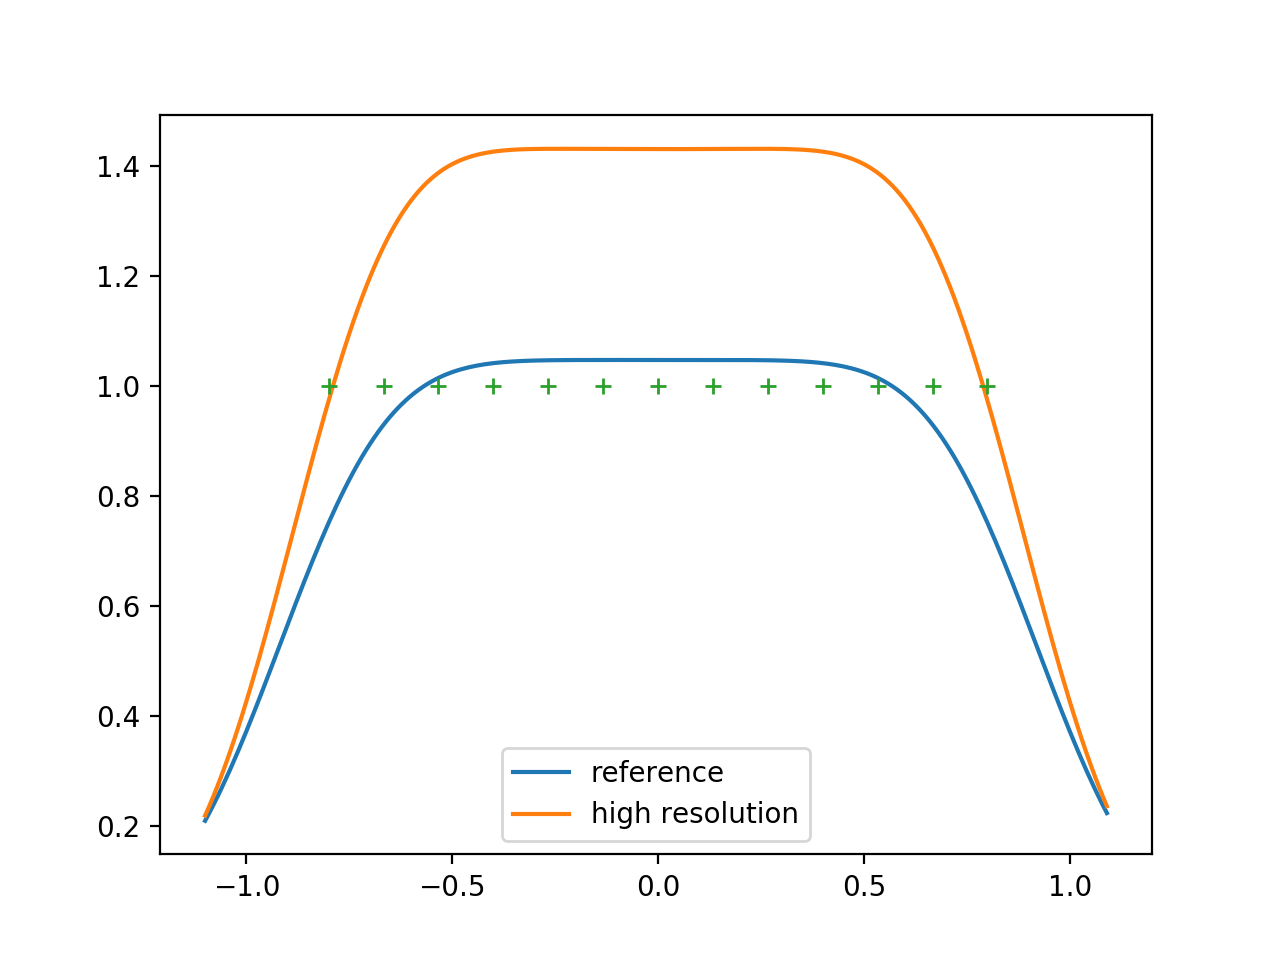

Metric: 1.3603733479358924


In [37]:
dcrMetric2_highres = DcrMetric2()
for measure in np.linspace(*dcrMetric2_highres.range, num=13, endpoint=True):
    airmass = np.abs(measure) + 1.
    ha = np.sign(measure)
    dcrMetric2_highres.addVisit(measure, airmass, ha)
dcrMetric2_reference.plotMetric(window=9, plot_measures=False)
dcrMetric2_highres.plotMetric(window=9)
plt.legend(['reference', 'high resolution'])
print(f"Metric: {dcrMetric2_highres.metric}")

## A narrow region of well-sampled airmass/hour angles should have a low overall metric.

While a proper DCR model may not be able to be created, traditional image differencing would work in this regime, however. 

<IPython.core.display.Javascript object>


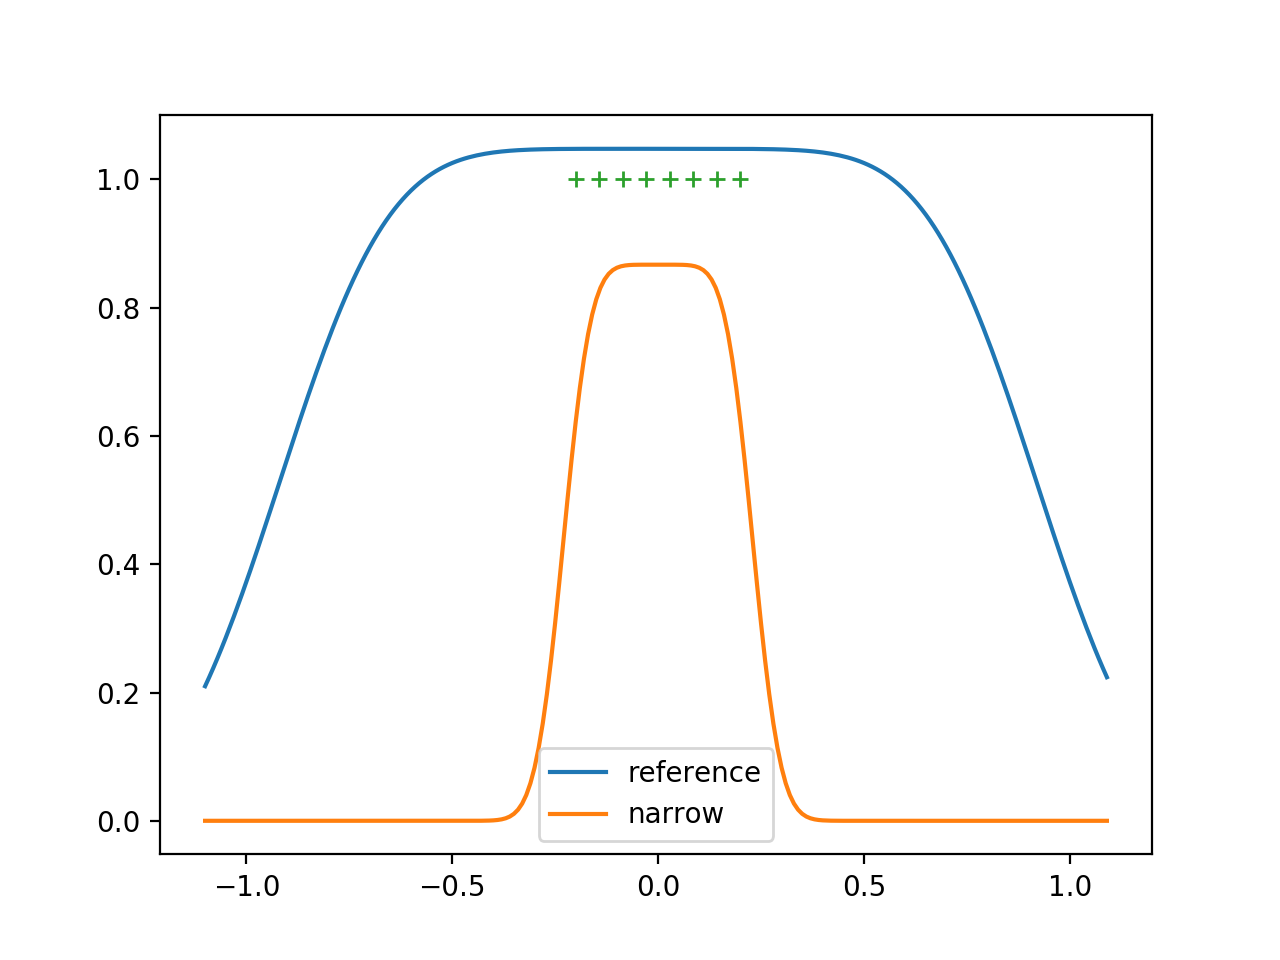

Metric: 0.24999999999999992


In [38]:
dcrMetric2_narrow = DcrMetric2()
for measure in np.linspace(-.2, .2, num=8, endpoint=True):
    airmass = np.abs(measure) + 1
    ha = np.sign(measure)
    dcrMetric2_narrow.addVisit(measure, airmass, ha)
dcrMetric2_reference.plotMetric(window=10, plot_measures=False)
dcrMetric2_narrow.plotMetric(window=10)
plt.legend(['reference', 'narrow'])
print(f"Metric: {dcrMetric2_narrow.metric}")

## Decreasing the number of visits should make the metric worse

<IPython.core.display.Javascript object>


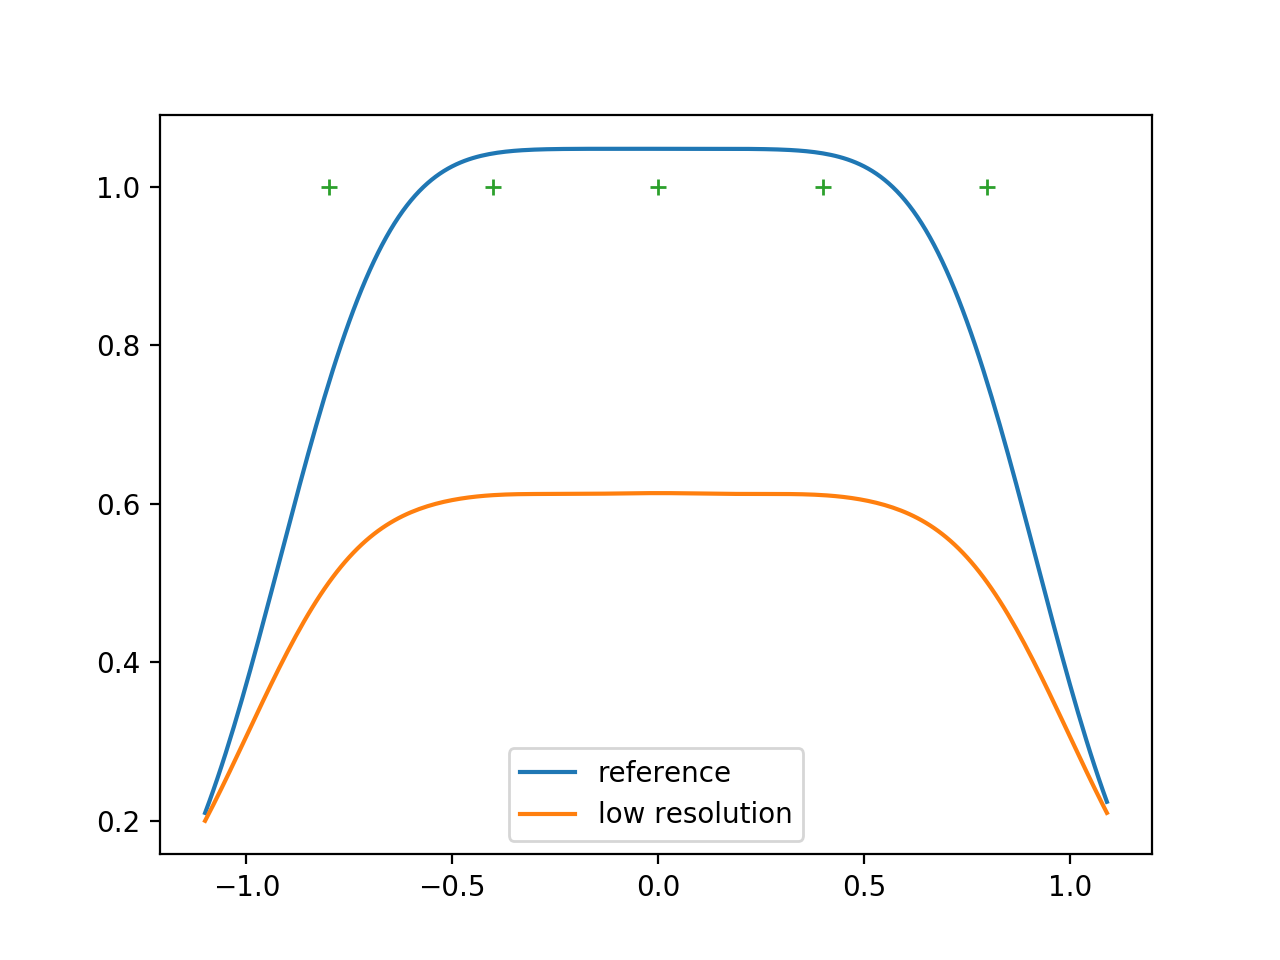

Metric: 0.5952208929069818


In [39]:
dcrMetric2_lowres = DcrMetric2()
for measure in np.linspace(*dcrMetric2_lowres.range, num=5, endpoint=True):
    airmass = np.abs(measure) + 1
    ha = np.sign(measure)
    dcrMetric2_lowres.addVisit(measure, airmass, ha)
dcrMetric2_reference.plotMetric(window=11, plot_measures=False)
dcrMetric2_lowres.plotMetric(window=11)
plt.legend(['reference', 'low resolution'])
print(f"Metric: {dcrMetric2_lowres.metric}")

## Adding more visits must not decrease the metric!

<IPython.core.display.Javascript object>


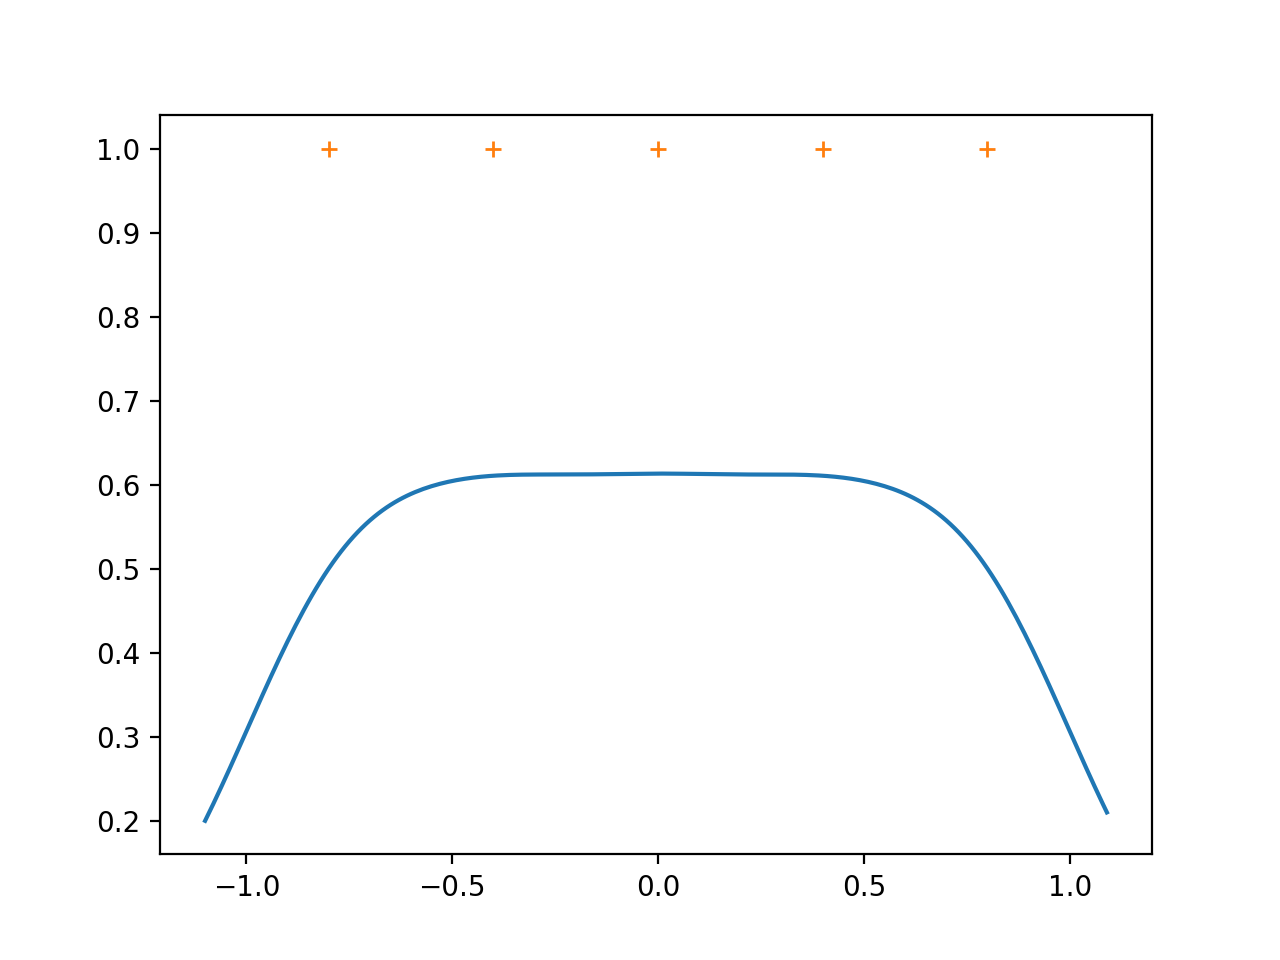

Metric: 0.5952208929069818


In [40]:
dcrMetric2_addvisits = DcrMetric2()
for measure in np.linspace(*dcrMetric2_addvisits.range, num=5, endpoint=True):
    airmass = np.abs(measure) + 1
    ha = np.sign(measure)
    dcrMetric2_addvisits.addVisit(f"{measure}", airmass, ha)
dcrMetric2_addvisits.plotMetric(window=12)
print(f"Metric: {dcrMetric2_addvisits.metric}")

## Now add more visits, and recalculate:

<IPython.core.display.Javascript object>


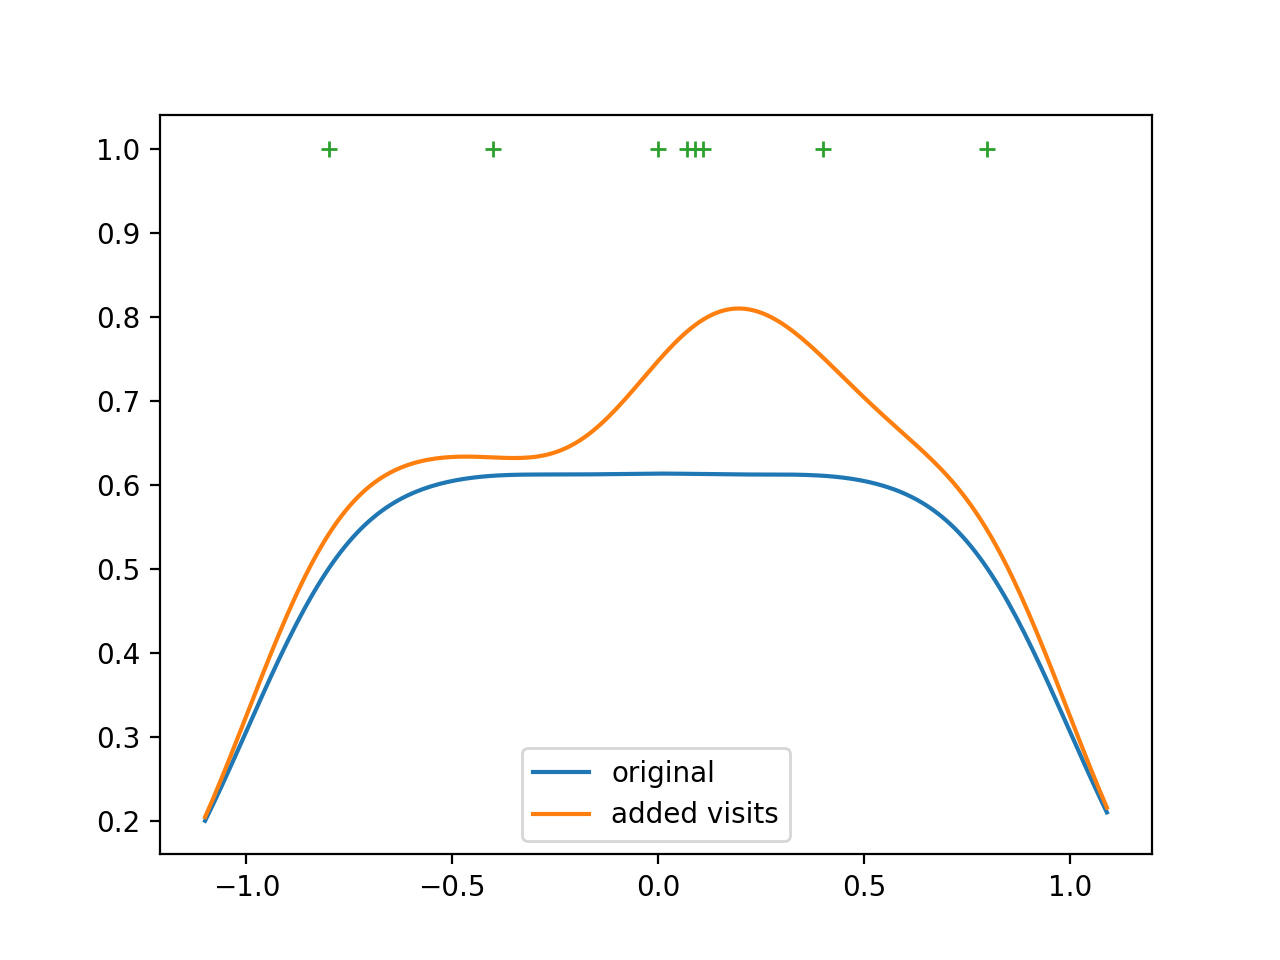

Metric: 0.6805622037937366


In [41]:
dcrMetric2_addvisits.plotMetric(window=13, plot_measures=False)
for airmass in np.linspace(1.07, 1.11, num=3):
    dcrMetric2_addvisits.addVisit(f"{airmass}b", airmass, 1.)
dcrMetric2_addvisits.plotMetric(window=13)
plt.legend(['original', 'added visits'])
print(f"Metric: {dcrMetric2_addvisits.metric}")

# What new visit would help constrain the model the most?

One of the primary purposes of the DCR metric is to determine how much a new observation will help constrain the model, and how much removing an existing observation would hurt it. 
As seen below, the metric is most improved by adding observations in the gaps between existing observations, and new observations at high airmass would be the most helpful overall.

<IPython.core.display.Javascript object>


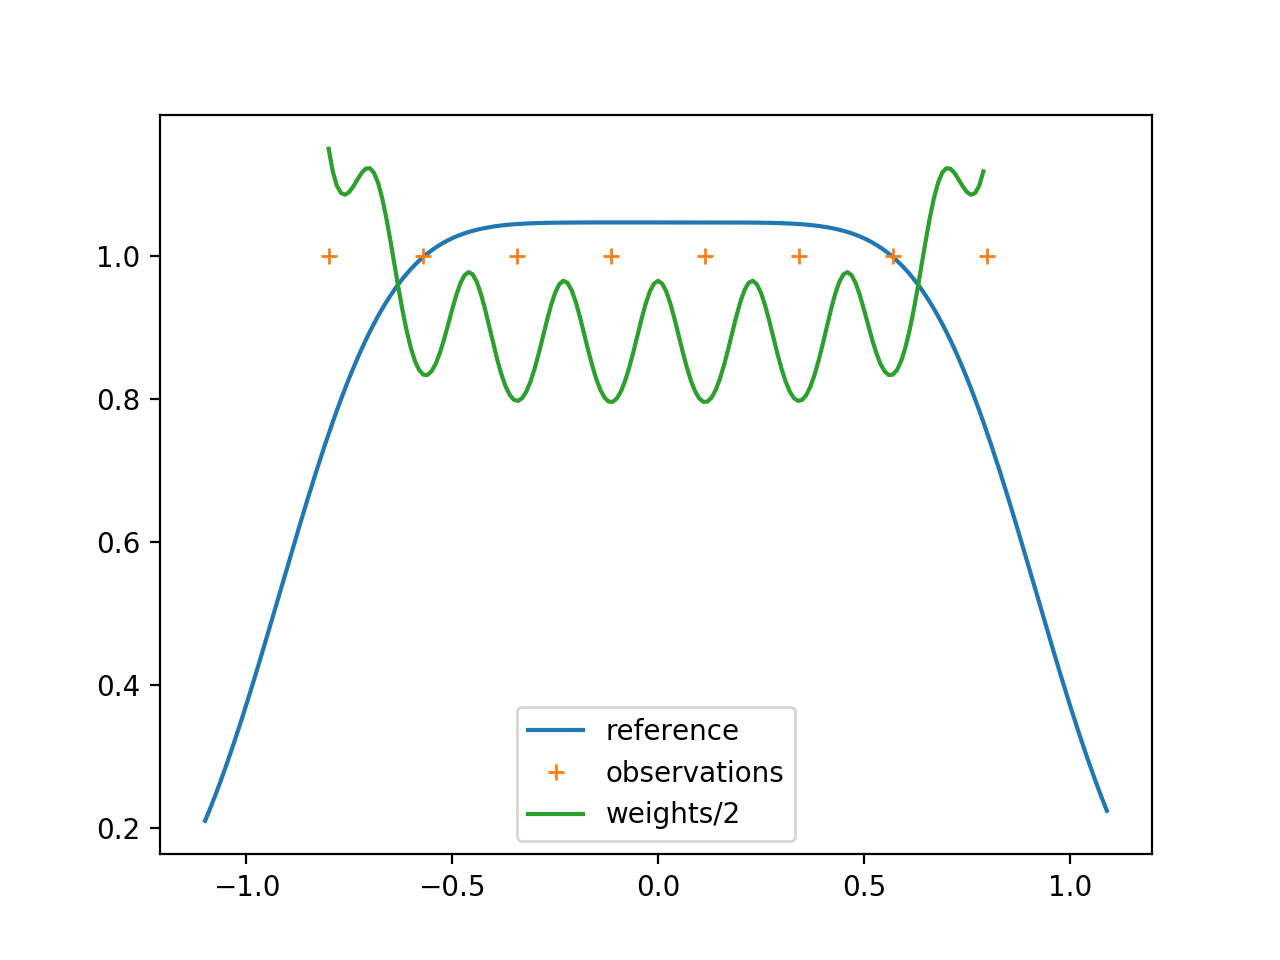

Metric: 1.0


In [42]:
dcrMetric2_weight = DcrMetric2()
for measure in np.linspace(*dcrMetric2_weight.range, num=8, endpoint=True):
    airmass = np.abs(measure) + 1.
    ha = np.sign(measure)
    dcrMetric2_weight.addVisit(measure, airmass, ha)
dcrMetric2_weight.plotMetric(window=14)
xv = np.arange(dcrMetric2_weight.range[0], dcrMetric2_weight.range[1], .01)
plt.figure(14)
metric_weights = dcrMetric2_weight.testVisit(visit_measure=xv)
# Note! I'm dividing the weights by 2 here to make them more easily comparable to the metric.
plt.plot(xv, metric_weights/2,'-')
plt.legend(['reference', 'observations', 'weights/2'])
print(f"Metric: {dcrMetric2_reference.metric}")

# Evaluate the HiTS 2014 and 2015 datasets we've been using for ap_pipe testing

In [43]:
dcrMetric2_hits2014 = DcrMetric2()
for vinfo in templateVinfos:
    dcrMetric2_hits2014.addVisitInfo(vinfo)

In [44]:
dcrMetric2_hits2015 = DcrMetric2()
for vinfo in alertsVinfos:
    dcrMetric2_hits2015.addVisitInfo(vinfo)

In [45]:
dcrMetric2_hits2014.calculateMetric()

0.4273382284763841

In [46]:
dcrMetric2_hits2015.calculateMetric()

1.0345743141292194

## Unlike the histogram method above, here the metric is normalized so that the threshold is 1
Thus the HiTS 2014 observations fall short of being able to constrain the DCR model, while the 2015 observations should be sufficient.

In [47]:
metric2_hits2014 = dcrMetric2_hits2014.evaluateVisit(test_airmass, test_ha)
metric2_hits2015 = dcrMetric2_hits2015.evaluateVisit(test_airmass, test_ha)

In [48]:
print(f"Science observation metric using 2014 template: {metric2_hits2014}")
print(f"Science observation metric using 2015 template: {metric2_hits2015}")

Science observation metric using 2014 template: [0.58428397]
Science observation metric using 2015 template: [0.99197932]


<IPython.core.display.Javascript object>


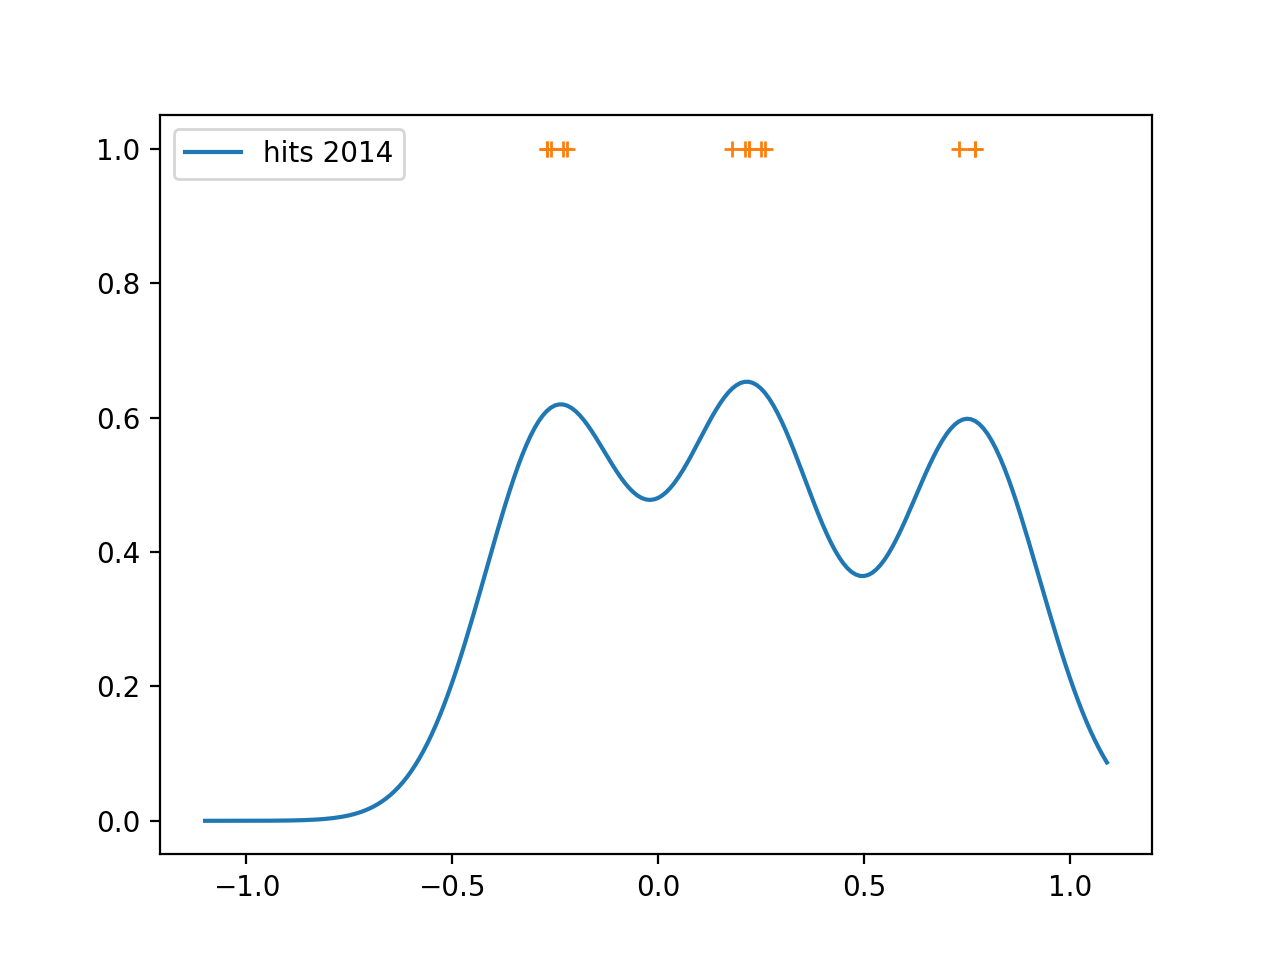

2014 metric: 0.4273382284763841


<IPython.core.display.Javascript object>


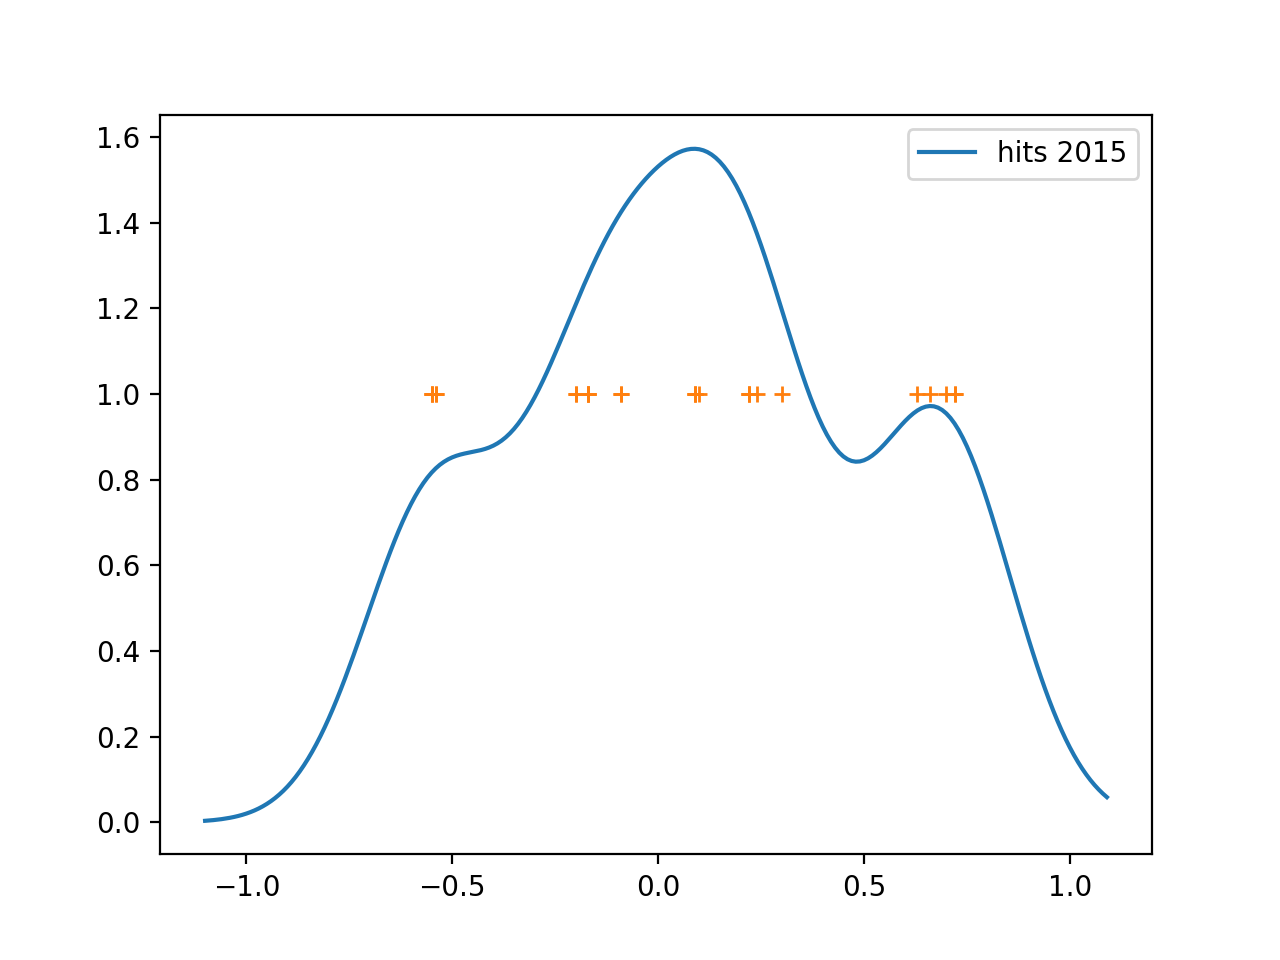

2015 metric: 1.0345743141292194


In [49]:
dcrMetric2_hits2014.plotMetric(window=15)
plt.legend(['hits 2014'])
print(f"2014 metric: {dcrMetric2_hits2014.metric}")
dcrMetric2_hits2015.plotMetric(window=16)
plt.legend(['hits 2015'])
print(f"2015 metric: {dcrMetric2_hits2015.metric}")


# Conclusions

Both forms of the DCR metric have the same basic functionality: they can evaluate a given set of observations and predict whether they will be sufficient to build a well-constrained DCR model, and they can evaluate the impact on that metric of adding or removing (say, from a best-seeing cut) observations.

The full KDE method gives more weight to repeated observations at similar observing conditions. This might give too much weight to a strongly modal distribution such as HiTS 2014, but in that case it was still not above the threshold.



Finally, some of the parameters may need to be tweaked for practical use. For example, we might want to calculate the metric over a narrower range of "visit measures" if the science observations are expected to have a limited range of airmasses.